<a href="https://colab.research.google.com/github/Som504/HumanDetection-Using-ResNet32/blob/main/RESNET_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf ## models
import numpy as np ## to match computations
import matplotlib.pyplot as plt ## to visualize and to plot bar chats
import tensorflow_datasets as tfds ## datasets
import tensorflow_probability as tfp

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer , MaxPooling2D , Flatten , Dense , BatchNormalization ,Input, Conv2D , MaxPool2D , Dropout , RandomFlip ,RandomRotation , Resizing , Rescaling , GlobalAveragePooling2D , Activation
from tensorflow.keras.losses import MeanSquaredError , Huber , MeanAbsoluteError , BinaryCrossentropy , CategoricalCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalsePositives,FalseNegatives, TruePositives,TrueNegatives,Precision ,Recall,AUC ,CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger , EarlyStopping ,LearningRateScheduler , ModelCheckpoint
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
import seaborn as sns
from google.colab import drive
import cv2 # Import cv2 here

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3
}


# DATA MANAGEMENT

## DATA DOWNLOADING

In [ ]:
!pip install -q kaggle # install kaggle


In [ ]:
! mkdir ~/.kaggle # create kaggle directory
! cp kaggle.json ~/.kaggle/ # copy json file there

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json # change the permission

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 99% 307M/309M [00:00<00:00, 316MB/s]
100% 309M/309M [00:00<00:00, 376MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## DATASET LOADING

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical", # to give numbers to image like 0 to happy 1 to sad
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels="inferred",
    label_mode="categorical", # to give numbers to image like 0 to happy 1 to sad
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


## DATA VISUALIZATION

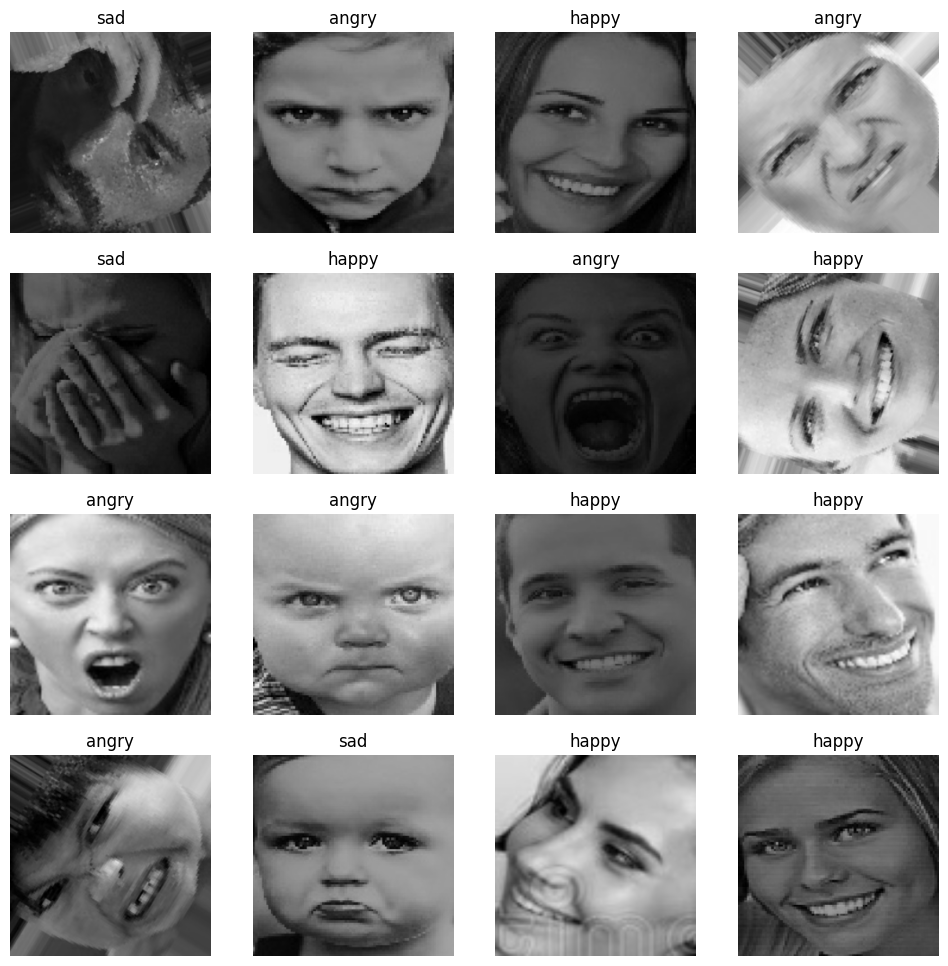

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i] , axis = 0).numpy()])
    plt.axis("off")

## DATASET PREPARATION

In [ ]:
training_dataset =(
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset =(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

# Data Augmentation

In [ ]:
### tf.image augment
@tf.function
def augment(image, label):
  image , label = resize_rescale(image , label)

  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)
  #image = tf.image.flip_up_down(image)


# Modeling

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(shape=(None, None, 3)),
    resize_rescale_layers,

    Conv2D(filters=CONFIGURATION["N_FILTERS"],kernel_size=CONFIGURATION["KERNEL_SIZE"],strides=CONFIGURATION["N_STRIDES"],
        activation='relu',kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPooling2D(
        pool_size=CONFIGURATION["POOL_SIZE"],
        strides=CONFIGURATION["N_STRIDES"] * 2
    ),

    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(
        filters=CONFIGURATION["N_FILTERS"] * 2 + 4,
        kernel_size=CONFIGURATION["KERNEL_SIZE"],
        strides=CONFIGURATION["N_STRIDES"],
        activation='relu',
        kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])
    ),
    BatchNormalization(),
    MaxPooling2D(
        pool_size=CONFIGURATION["POOL_SIZE"],
        strides=CONFIGURATION["N_STRIDES"] * 2
    ),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation='relu', kernel_regularizer= L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["N_DENSE_2"], activation='relu', kernel_regularizer= L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')

])

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

# ResNet Complete Network

## Custom Conv2D Layer

In [ ]:
class CustomConv2D(Layer):
  def __init__(self , n_filters , kernel_size , n_strides , padding = 'valid'):
    super(CustomConv2D , self).__init__(name = 'custom_conv_2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding,
    )

    self.batch_norm = BatchNormalization()

  def call(self , x ,training=True):

    x = self.conv(x)
    x = self.batch_norm(x , training = training)

    return x

## Residual Block

In [ ]:
from os import name
from tensorflow.keras.layers import Activation, Add
class ResidualBlock(Layer):
  def __init__(self , n_channels , n_strides = 1):
    super(ResidualBlock , self).__init__(name = 'residual_block')

    self.dotted = (n_strides != 1)

    self.conv_1 = CustomConv2D(n_filters = n_channels , kernel_size = 3 , n_strides = n_strides , padding = 'same')
    self.conv_2 = CustomConv2D(n_filters = n_channels , kernel_size = 3 , n_strides = 1 , padding = 'same')

    self.activation = Activation('relu')

    if self.dotted :
      self.custom_conv_3 = CustomConv2D(n_filters = n_channels , kernel_size = 1 , n_strides = n_strides)

  def call(self , input , training):


    x = self.conv_1(input , training = training)
    x = self.conv_2(x , training = training)

    if self.dotted :
      x_add = self.custom_conv_3(input , training = training)
      x_add = Add()([x , x_add])
    else:
      x_add = Add()([x , input])

    return self.activation(x_add)

## Complete Network

In [ ]:
class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name = 'resnet_34')

        self.conv_1 = CustomConv2D(64 , 7 , 2 , padding = 'same')
        self.max_pool = MaxPooling2D(pool_size = 3 , strides = 2 )

        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)

        self.conv_3_1 = ResidualBlock(128 ,  2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)

        self.conv_4_1 = ResidualBlock(256 ,  2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)

        self.conv_5_1 = ResidualBlock(512 ,  2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()

        self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"] , activation = 'softmax')

    def call(self , x , training = True):
        x = self.conv_1(x)
        x = self.max_pool(x)

        x = self.conv_2_1(x , training = training)
        x = self.conv_2_2(x, training = training)
        x = self.conv_2_3(x , training = training)

        x = self.conv_3_1(x , training = training)
        x = self.conv_3_2(x, training = training)
        x = self.conv_3_3(x, training = training)
        x = self.conv_3_4(x, training = training)

        x = self.conv_4_1(x, training = training)
        x = self.conv_4_2(x, training = training)
        x = self.conv_4_3(x, training = training)
        x = self.conv_4_4(x, training = training)
        x = self.conv_4_5(x, training = training)
        x = self.conv_4_6(x, training = training)

        x = self.conv_5_1(x, training = training)
        x = self.conv_5_2(x, training = training)
        x = self.conv_5_3(x, training = training)

        x = self.global_pool(x)

        return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training=False)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv_2d (CustomConv2D)   │ ?                      │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

# TRAINING

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
)

In [ ]:
loss_function = CategoricalCrossentropy(from_logits= False)

In [ ]:
metrics = [CategoricalAccuracy(name =  "accuracy") , TopKCategoricalAccuracy(k = 2 , name = "top_k_accuracy")]

In [ ]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_34.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"]*3,
    verbose = 1,
    callbacks = [checkpoint_callback]
)

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.3960 - loss: 2.3347 - top_k_accuracy: 0.7221
Epoch 1: val_accuracy improved from -inf to 0.42669, saving model to weights.01-1.38.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 114s 347ms/step - accuracy: 0.3961 - loss: 2.3307 - top_k_accuracy: 0.7222 - val_accuracy: 0.4267 - val_loss: 1.3832 - val_top_k_accuracy: 0.7480
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4783 - loss: 1.0739 - top_k_accuracy: 0.7710
Epoch 2: val_accuracy improved from 0.42669 to 0.47191, saving model to weights.02-1.42.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 107s 262ms/step - accuracy: 0.4783 - loss: 1.0738 - top_k_accuracy: 0.7710 - val_accuracy: 0.4719 - val_loss: 1.4155 - val_top_k_accuracy: 0.7520
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5164 - loss: 1.0211 - top_k_accuracy: 0.7908
Epoch 3: val_accuracy did not improve from 0.47191
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 239ms/step - accuracy: 0.5164 - loss: 1.02

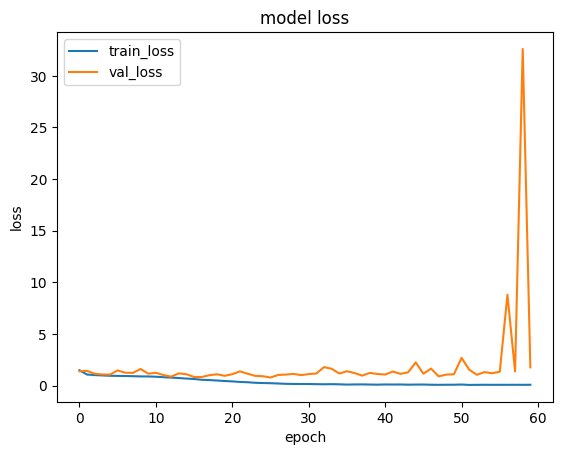

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

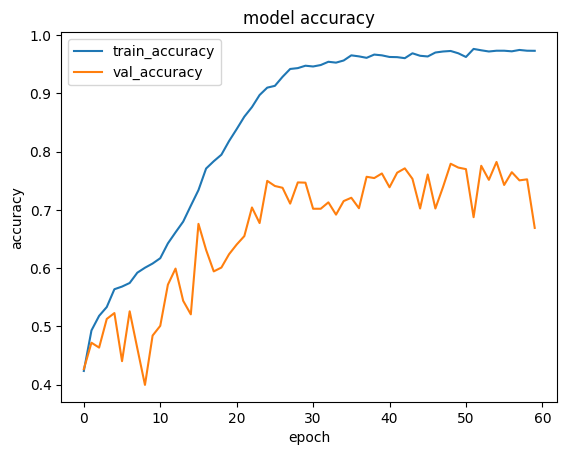

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()


# Evaluation

In [ ]:
resnet_34.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7847 - loss: 1.7417 - top_k_accuracy: 0.9171


[1.6899491548538208, 0.7892888784408569, 0.9223002791404724]

# Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")

im = tf.constant(test_image , dtype = tf.float32)

im = tf.expand_dims(im, axis =0)

print(resnet_34(im))

print(CLASS_NAMES[tf.argmax(resnet_34(im) , axis = 1).numpy()[0]])

tf.Tensor([[0.00395601 0.8106761  0.18536793]], shape=(1, 3), dtype=float32)
happy


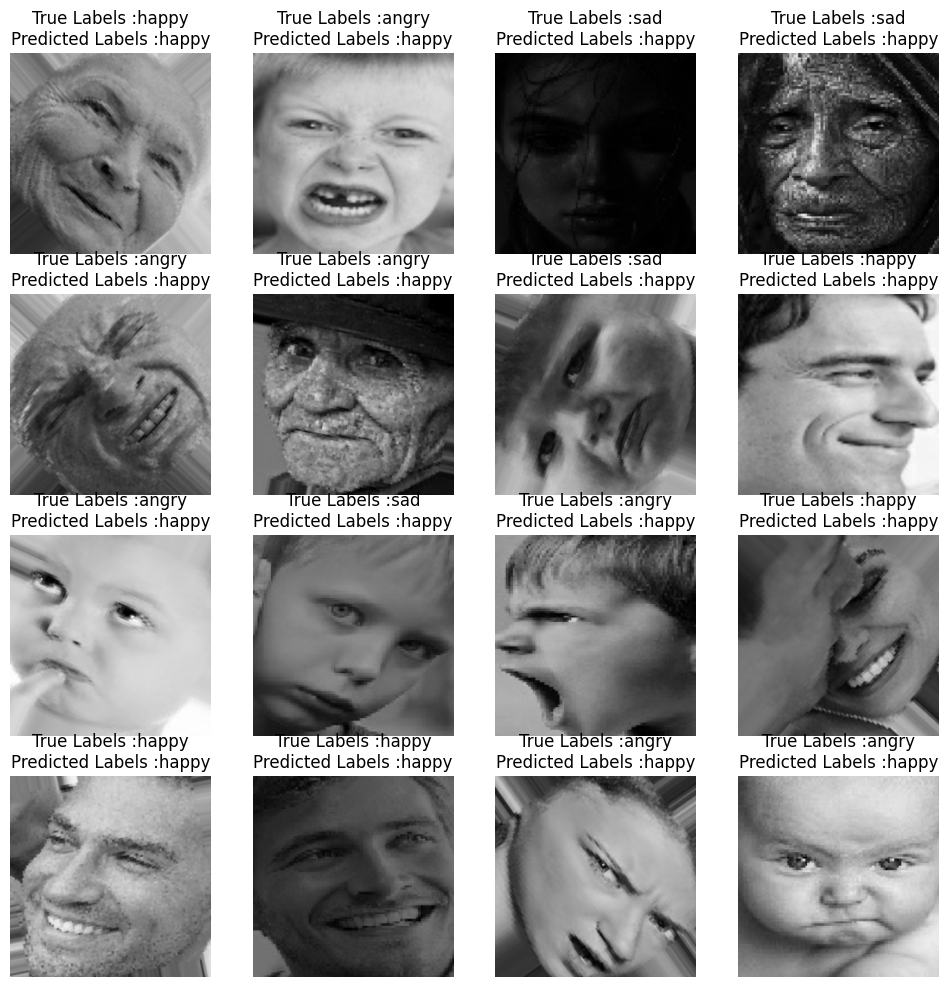

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Labels :" + CLASS_NAMES[tf.argmax(labels[i] , axis = 0).numpy()] + "\n" + "Predicted Labels :" + CLASS_NAMES[int(tf.argmax(resnet_34(tf.expand_dims(images[i], axis =0)) , axis = -1).numpy()[0])])
    plt.axis("off")

# Confusion Matrix

In [ ]:
predicted = []
labels = []

for im,label in validation_dataset :
  predicted.append(resnet_34(im))
  labels.append(label.numpy())

In [ ]:
# print(len(np.argmax(labels[:-1] , axis = -1).flatten()))
# print((np.argmax(labels[:-1] , axis = -1).flatten()))
# print((np.argmax(predicted[:-1] , axis = -1).flatten()))
print(np.concatenate([(np.argmax(labels[:-1] , axis = -1).flatten()) , np.argmax(labels[-1:] , axis = -1).flatten()]))
print(np.concatenate([(np.argmax(predicted[:-1] , axis = -1).flatten()) , np.argmax(predicted[-1:] , axis = -1).flatten()]))

[2 1 2 ... 0 2 0]
[2 1 2 ... 1 2 0]


In [ ]:
# pred = ((np.argmax(predicted[:-1] , axis = -1).flatten()))
# lab = ((np.argmax(labels[:-1] , axis = -1).flatten()))

lab = np.concatenate([(np.argmax(labels[:-1] , axis = -1).flatten()) , np.argmax(labels[-1] , axis = -1).flatten()])
pred = np.concatenate([(np.argmax(predicted[:-1] , axis = -1).flatten()) , np.argmax(predicted[-1] , axis = -1).flatten()])

[[376  63  76]
 [ 39 882  85]
 [ 79 116 562]]


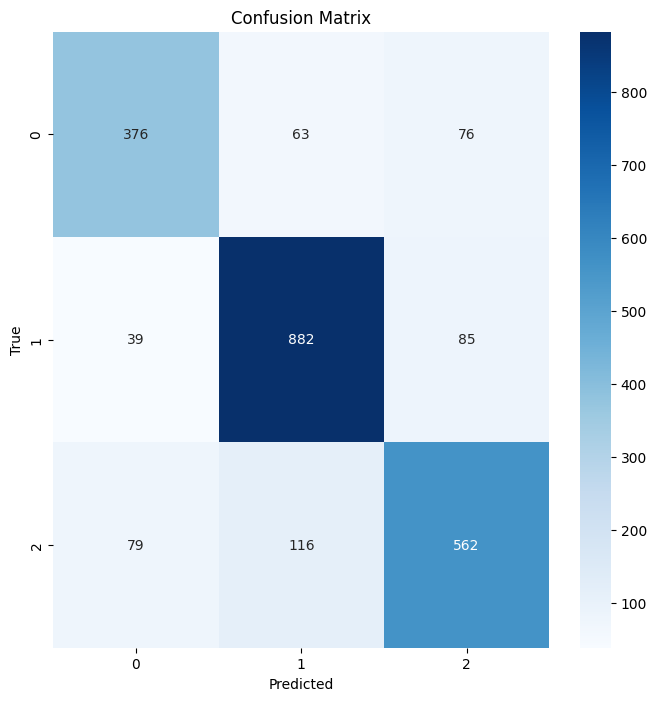

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()